## 인공신경망

### Custom Layer 작성

#### 자체 신경망 Layer 만들기

- PyTorch에서 자체 신경망 layer 생성시 nn.Module을 상속하여 클래스 정의
    - nn.Module은 nn.Linear를 포함한 모든 계층의 기반 클래스
    - super().__ init __() 메서드 호출을 통해 nn.Module 속성들 초기화

#### Custom Layer 제작 시, forward() 메서드 구현을 통해 자동미분까지 가능

- nn.Module의 __ call __() 메서드는 내부에서 forward() 메서드를 정의
- nn.Module을 상속받는 클래스에서 forward() 메서드를 정의하지 않을 경우 NotImplementedError 발생
- y = model(x) 형태의 이용이 가능했던 이유


#### 시작

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler

from torchvision import datasets
import torchvision.transforms as transforms

import numpy as np

##### CustomLayer 1

In [6]:
model = nn.Sequential(
    nn.Linear(2, 10, bias=True),
    nn.Sigmoid(),
    nn.Linear(10, 10, bias=True), ## 여기와
    nn.Sigmoid(), ## 여기 반복
    nn.Linear(10, 10, bias=True),
    nn.Sigmoid(),
    nn.Linear(10, 1, bias=True),
    nn.Sigmoid()
)

In [8]:
class CustomLayer(nn.Module):
    def __init__(self, in_nodes, out_nodes):
        super(CustomLayer, self).__init__() # base class 초기화

        self.linear = nn.Linear(in_nodes, out_nodes, bias=True)
        self.activation = nn.Sigmoid()

    def forward(self, x):
        x = self.activation(self.linear(x))
        return x

In [9]:
## 변경
model = nn.Sequential(
    nn.Linear(2, 10, bias=True),
    nn.Sigmoid(),
    CustomLayer(10, 10),
    CustomLayer(10, 10),
    nn.Linear(10, 1, bias=True),
    nn.Sigmoid()
)

In [10]:
model

Sequential(
  (0): Linear(in_features=2, out_features=10, bias=True)
  (1): Sigmoid()
  (2): CustomLayer(
    (linear): Linear(in_features=10, out_features=10, bias=True)
    (activation): Sigmoid()
  )
  (3): CustomLayer(
    (linear): Linear(in_features=10, out_features=10, bias=True)
    (activation): Sigmoid()
  )
  (4): Linear(in_features=10, out_features=1, bias=True)
  (5): Sigmoid()
)

##### CustomLayer 2

In [11]:
class CustomNetwork(nn.Module):
    def __init__(self, n_nodes):
        super(CustomNetwork, self).__init__() ## base class 초기화

        self.linear1 = nn.Linear(2, n_nodes)
        self.linear2 = nn.Linear(n_nodes, n_nodes)
        self.linear3 = nn.Linear(n_nodes, n_nodes)
        self.linear4 = nn.Linear(n_nodes, 1)
        self.activation = nn.Sigmoid()

    def forward(self, x):
        x = self.activation(self.linear1(x))
        x = self.activation(self.linear2(x))
        x = self.activation(self.linear3(x))
        x = self.activation(self.linear4(x))
        return x

In [12]:
model = CustomNetwork(10)

In [13]:
model

CustomNetwork(
  (linear1): Linear(in_features=2, out_features=10, bias=True)
  (linear2): Linear(in_features=10, out_features=10, bias=True)
  (linear3): Linear(in_features=10, out_features=10, bias=True)
  (linear4): Linear(in_features=10, out_features=1, bias=True)
  (activation): Sigmoid()
)

##### Custom 신경망 XOR 문제

In [14]:
import torch 
import torch.nn as nn

In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
X = torch.FloatTensor([[0,0],[0,1],[1,0],[1,1]]).to(device)
Y = torch.FloatTensor([[0],[1],[1],[0]]).to(device)

model = CustomNetwork(10).to(device)
criterion = nn.BCELoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1) # learning rate 를 0.1부터 1까지 조정해볼 것

In [16]:
for epoch in range(10001):
    optimizer.zero_grad()
    hypothesis = model(X)

    cost = criterion(hypothesis, Y)  # 비용은 가설과 출력값을 통해 구함
    cost.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f'Epoch : {epoch:04d}, Cost : {cost.item():.9f}')

Epoch : 0000, Cost : 0.696675062
Epoch : 0100, Cost : 0.693145692
Epoch : 0200, Cost : 0.693145394
Epoch : 0300, Cost : 0.693144977
Epoch : 0400, Cost : 0.693144619
Epoch : 0500, Cost : 0.693144202
Epoch : 0600, Cost : 0.693143785
Epoch : 0700, Cost : 0.693143368
Epoch : 0800, Cost : 0.693142891
Epoch : 0900, Cost : 0.693142474
Epoch : 1000, Cost : 0.693142056
Epoch : 1100, Cost : 0.693141580
Epoch : 1200, Cost : 0.693141162
Epoch : 1300, Cost : 0.693140626
Epoch : 1400, Cost : 0.693140149
Epoch : 1500, Cost : 0.693139553
Epoch : 1600, Cost : 0.693139076
Epoch : 1700, Cost : 0.693138480
Epoch : 1800, Cost : 0.693137884
Epoch : 1900, Cost : 0.693137228
Epoch : 2000, Cost : 0.693136573
Epoch : 2100, Cost : 0.693135738
Epoch : 2200, Cost : 0.693135023
Epoch : 2300, Cost : 0.693134308
Epoch : 2400, Cost : 0.693133414
Epoch : 2500, Cost : 0.693132520
Epoch : 2600, Cost : 0.693131566
Epoch : 2700, Cost : 0.693130612
Epoch : 2800, Cost : 0.693129539
Epoch : 2900, Cost : 0.693128407
Epoch : 30

In [17]:
with torch.no_grad():
    hypothesis = model(X)
    predicted = (hypothesis > 0.5).float()
    accuracy = (predicted == Y).float().mean()

    print(f'모델의 출력값(Hypothesis): {hypothesis.detach().cpu().numpy()}')
    print(f'모델의 예측값(Predicted): {predicted.detach().cpu().numpy()}')
    print(f'실제값(Y): {Y.cpu().numpy()}')
    print(f'정확도(Accuracy): {accuracy.item()}')

모델의 출력값(Hypothesis): [[1.7573987e-04]
 [9.9978429e-01]
 [9.9978071e-01]
 [2.9291309e-04]]
모델의 예측값(Predicted): [[0.]
 [1.]
 [1.]
 [0.]]
실제값(Y): [[0.]
 [1.]
 [1.]
 [0.]]
정확도(Accuracy): 1.0


### Optimizer

#### Gradient 잡음현상
- 훈련 세트를 이용하여 그래디언트 추정하면 잡음 가능성이 높음
- 모멘텀 - 그래디언트에 스무딩을 가하여 잡음효과를 줄여서 수렴 속도를 향상

#### Learning rate 중요성
- 너무 클 경우 오버슈팅에 따른 발산 발생
- 너무 작을 경우 수렴이 느림

#### Adaptive Learning Rate
- AdaGrad(Adaptive Gradient)
- RMSProp (Root Mean Square Propagation) - AdaGrad 단점 해결
- Adam(Adaptive Momemtum Estimation) - RMSProp + Momentum

    <img src="https://raw.githubusercontent.com/hugoMGSung/study-pytorch/refs/heads/main/images/torch0015.png" width="600">

### Optimizer 실습

#### Circle Classification

In [18]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets

In [19]:
torch.manual_seed(123)

num_data = 500
X, Y = datasets.make_circles(
    n_samples=num_data, random_state=123, noise=0.2, factor=0.3
) ## data 생성

x_data = torch.Tensor(X)
y_data = torch.Tensor(Y.reshape(num_data, 1))

print(x_data.shape, y_data.shape, sep='\n')  ## (500, 2), (500, 1)

torch.Size([500, 2])
torch.Size([500, 1])


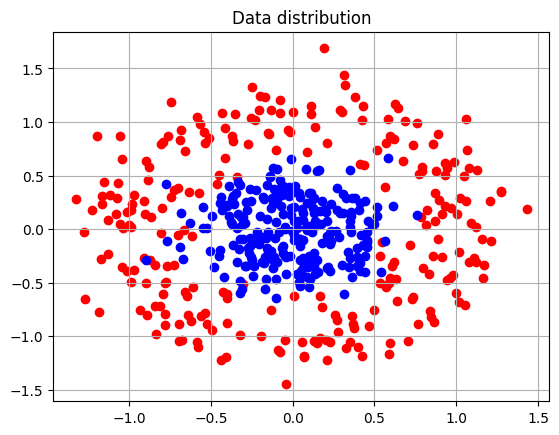

In [23]:
## 데이터의 상황확인
plt.scatter(X[Y == 0, 0], X[Y == 0, 1], color='red')
plt.scatter(X[Y == 1, 0], X[Y == 1, 1], color='blue')
plt.grid()
plt.title('Data distribution')
plt.show()

##### SGD 옵티마이저

In [28]:
class Network(nn.Module):
    def __init__(self, number_node):
        super().__init__()
        self.linear1 = nn.Linear(2, number_node)
        self.linear2 = nn.Linear(number_node, 1)
        self.activation = nn.Sigmoid()

    def forward(self, x):
        x = self.activation(self.linear1(x))
        x = self.activation(self.linear2(x))    
        return x 

model = Network(4)

In [33]:
net_params = model.parameters()
optimizer = torch.optim.SGD(net_params, lr=0.01)

criterion = nn.BCELoss()

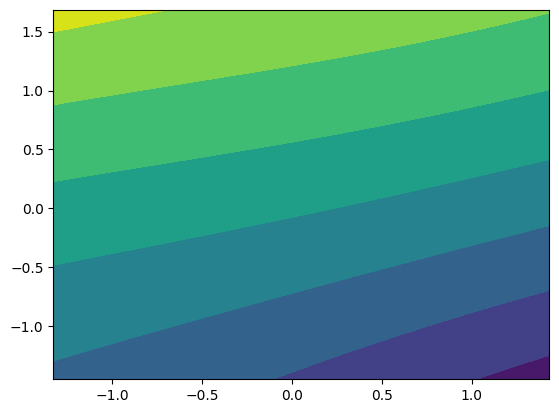

In [34]:
epochs = 1000
losses = []

for i in range(epochs):
    optimizer.zero_grad()
    y_pred = model(x_data)
    loss = criterion(y_pred, y_data)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

x1_span = np.linspace(min(X[:, 0]), max(X[:, 0]))
x2_span = np.linspace(min(X[:, 1]), max(X[:, 1]))
xx1, xx2 = np.meshgrid(x1_span, x2_span)
grid = torch.Tensor(np.c_[xx1.ravel(), xx2.ravel()])
pred_func = model(grid)
z = pred_func.view(xx1.shape).detach().numpy()

plt.contourf(xx1, xx2, z)
plt.show()

##### 분류가 되지 않음 

##### Adam 옵티마이저로 변경

In [35]:
net_params = model.parameters()
optimizer = torch.optim.Adam(net_params, lr=0.01, betas=(0.9, 0.999))

criterion = nn.BCELoss()

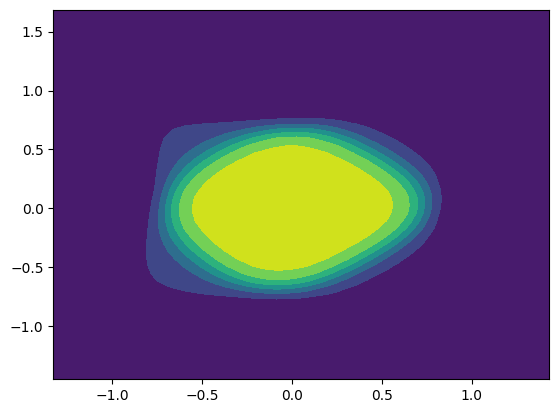

In [36]:
epochs = 1000
losses = []

for i in range(epochs):
    optimizer.zero_grad()
    y_pred = model(x_data)
    loss = criterion(y_pred, y_data)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

x1_span = np.linspace(min(X[:, 0]), max(X[:, 0]))
x2_span = np.linspace(min(X[:, 1]), max(X[:, 1]))
xx1, xx2 = np.meshgrid(x1_span, x2_span)
grid = torch.Tensor(np.c_[xx1.ravel(), xx2.ravel()])
pred_func = model(grid)
z = pred_func.view(xx1.shape).detach().numpy()

plt.contourf(xx1, xx2, z)
plt.show()

##### 분류가 잘됨